# 0. install packages



In [58]:
!pip install langchain
!pip install openai
!pip install tiktoken
!pip install -U sentence-transformers

In [59]:
import pandas as pd
from getpass import getpass
import os
from langchain.evaluation import load_evaluator
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# 1. Load the questions and answers


In [60]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
file_path = '/content/drive/MyDrive/UR/Data/qa.csv'

df = pd.read_csv(file_path)

df.head()

,Nr.,question,nlp_related,expert,lc_bot,chat_gpt
0,1,What is the purpose of Regular Expressions in ...,1,Regular Expressions (regex) are essential tool...,Regular Expressions (regex) are an important t...,Regular Expressions (regex) play a vital role ...
1,2,Explain the concept of Vector Semantics and Em...,1,Vector semantics and embeddings play a crucial...,Vector semantics and embeddings are concepts u...,Vector semantics and embeddings are fundamenta...
2,3,"What is an N-gram language model, and how is i...",1,An N-gram language model is a statistical mode...,An N-gram language model is a type of language...,An N-gram language model is a statistical lang...
3,4,How does the Naive Bayes algorithm work in tex...,1,The Naive Bayes algorithm is a probabilistic ...,The Naive Bayes algorithm is used in text clas...,The Naive Bayes algorithm is a probabilistic m...
4,5,"How is logistic regression applied in NLP, and...",1,Logistic regression is a popular machine learn...,Logistic regression is commonly applied in Nat...,Logistic regression is a popular and simple ma...


# 2. Evaluation: calculate the scores by comparing the output embeddings
## 2.1 Pairwise embedding distance (LangChain/OpenAI)

The Pairwise Embedding Distance measures the vector distance (cosine) between the two embeddings (OpenAI).

**Note**: This returns a **distance** score, meaning that the **lower** the number, the **more** similar the outputs are, according to their embedded representation.

[LangChain documentation](https://python.langchain.com/docs/guides/evaluation/comparison/pairwise_embedding_distance)

In [62]:
# get API-Key
OPENAI_API_KEY = getpass('Enter OpenAi API key: ')

Enter OpenAi API key: ··········


In [63]:
# set API key as environment variable
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [64]:
# load evaluator
evaluator = load_evaluator("pairwise_embedding_distance")

In [65]:
# Pairwise Embedding Score for Expert/Lingception Bot
df['pes_lc_bot'] = df.apply(lambda row: evaluator({'prediction_b': row['expert'], 'prediction': row['lc_bot']})['score'], axis=1)

In [66]:
# Pairwise Embedding Score for Expert/ChatGPT
df['pes_chat_gpt'] = df.apply(lambda row: evaluator({'prediction_b': row['expert'], 'prediction': row['chat_gpt']})['score'], axis=1)

In [67]:
df

,Nr.,question,nlp_related,expert,lc_bot,chat_gpt,pes_lc_bot,pes_chat_gpt
0,1,What is the purpose of Regular Expressions in ...,1,Regular Expressions (regex) are essential tool...,Regular Expressions (regex) are an important t...,Regular Expressions (regex) play a vital role ...,0.025363,0.026308
1,2,Explain the concept of Vector Semantics and Em...,1,Vector semantics and embeddings play a crucial...,Vector semantics and embeddings are concepts u...,Vector semantics and embeddings are fundamenta...,0.037887,0.027823
2,3,"What is an N-gram language model, and how is i...",1,An N-gram language model is a statistical mode...,An N-gram language model is a type of language...,An N-gram language model is a statistical lang...,0.022265,0.026686
3,4,How does the Naive Bayes algorithm work in tex...,1,The Naive Bayes algorithm is a probabilistic ...,The Naive Bayes algorithm is used in text clas...,The Naive Bayes algorithm is a probabilistic m...,0.042236,0.033667
4,5,"How is logistic regression applied in NLP, and...",1,Logistic regression is a popular machine learn...,Logistic regression is commonly applied in Nat...,Logistic regression is a popular and simple ma...,0.041551,0.030804
5,6,What are the key benefits of using vector sema...,1,Vector semantics and word embeddings offer sev...,The key benefits of using vector semantics and...,Vector semantics and word embeddings have revo...,0.032650,0.022005
6,7,How do neural networks and neural language mod...,1,Neural networks and neural language models hav...,Neural networks and neural language models con...,Neural networks and neural language models hav...,0.046536,0.036877
7,8,"What is sequence labeling in NLP, and how is i...",1,Sequence labeling is a type of NLP task where ...,Sequence labeling in NLP refers to the task of...,Sequence labeling is a natural language proces...,0.027210,0.020265
8,9,What are Recurrent Neural Networks (RNNs) and ...,1,RNNs and LSTMs are types of neural network arc...,Recurrent Neural Networks (RNNs) are a type of...,Recurrent Neural Networks (RNNs) and Long Shor...,0.041825,0.026892
9,10,"What are transformers, and how have pretrained...",1,Transformers are a type of neural network arch...,Transformers are a type of architecture common...,Transformers are a type of deep learning model...,0.033043,0.028876


## 2.2 Semantic answer similarity (HuggingFace)

The chosen model calculates the cosine similarity of two given output texts.

**Note**: This returns a **similarity** score, meaning that the **higher** the number, the **more** similar the outputs are, according to their embedded representation.

[HuggingFace documentation](https://huggingface.co/tasks/sentence-similarity)

[Sentence Similarity Usage / sbert.net](https://www.sbert.net/docs/usage/semantic_textual_similarity.html)

Model: [all-mpnet-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2), Benchmark: [sbert.net](https://www.sbert.net/docs/pretrained_models.html)

In [68]:
# Semantic Answer Similarity for Expert / Lingception Bot
model = SentenceTransformer('all-MiniLM-L6-v2')

df['sas_lc_bot'] = float('NaN')

for index, row in df.iterrows():
    expert_text = row['expert']
    chat_gpt_text = row['lc_bot']

    expert_embedding = model.encode(expert_text, convert_to_tensor=True)
    chat_gpt_embedding = model.encode(chat_gpt_text, convert_to_tensor=True)

    df.at[index, 'sas_lc_bot'] = util.pytorch_cos_sim(expert_embedding, chat_gpt_embedding).item()

In [69]:
# Semantic Answer Similarity for Expert / ChatGPT
df['sas_chat_gpt'] = float('NaN')

for index, row in df.iterrows():
    expert_text = row['expert']
    chat_gpt_text = row['chat_gpt']

    expert_embedding = model.encode(expert_text, convert_to_tensor=True)
    chat_gpt_embedding = model.encode(chat_gpt_text, convert_to_tensor=True)

    df.at[index, 'sas_chat_gpt'] = util.pytorch_cos_sim(expert_embedding, chat_gpt_embedding).item()

In [70]:
df

,Nr.,question,nlp_related,expert,lc_bot,chat_gpt,pes_lc_bot,pes_chat_gpt,sas_lc_bot,sas_chat_gpt
0,1,What is the purpose of Regular Expressions in ...,1,Regular Expressions (regex) are essential tool...,Regular Expressions (regex) are an important t...,Regular Expressions (regex) play a vital role ...,0.025363,0.026308,0.931940,0.909327
1,2,Explain the concept of Vector Semantics and Em...,1,Vector semantics and embeddings play a crucial...,Vector semantics and embeddings are concepts u...,Vector semantics and embeddings are fundamenta...,0.037887,0.027823,0.816989,0.751875
2,3,"What is an N-gram language model, and how is i...",1,An N-gram language model is a statistical mode...,An N-gram language model is a type of language...,An N-gram language model is a statistical lang...,0.022265,0.026686,0.910051,0.871587
3,4,How does the Naive Bayes algorithm work in tex...,1,The Naive Bayes algorithm is a probabilistic ...,The Naive Bayes algorithm is used in text clas...,The Naive Bayes algorithm is a probabilistic m...,0.042236,0.033667,0.852584,0.864081
4,5,"How is logistic regression applied in NLP, and...",1,Logistic regression is a popular machine learn...,Logistic regression is commonly applied in Nat...,Logistic regression is a popular and simple ma...,0.041551,0.030804,0.834207,0.863243
5,6,What are the key benefits of using vector sema...,1,Vector semantics and word embeddings offer sev...,The key benefits of using vector semantics and...,Vector semantics and word embeddings have revo...,0.032650,0.022005,0.856069,0.910196
6,7,How do neural networks and neural language mod...,1,Neural networks and neural language models hav...,Neural networks and neural language models con...,Neural networks and neural language models hav...,0.046536,0.036877,0.744532,0.833083
7,8,"What is sequence labeling in NLP, and how is i...",1,Sequence labeling is a type of NLP task where ...,Sequence labeling in NLP refers to the task of...,Sequence labeling is a natural language proces...,0.027210,0.020265,0.874980,0.865987
8,9,What are Recurrent Neural Networks (RNNs) and ...,1,RNNs and LSTMs are types of neural network arc...,Recurrent Neural Networks (RNNs) are a type of...,Recurrent Neural Networks (RNNs) and Long Shor...,0.041825,0.026892,0.875519,0.896799
9,10,"What are transformers, and how have pretrained...",1,Transformers are a type of neural network arch...,Transformers are a type of architecture common...,Transformers are a type of deep learning model...,0.033043,0.028876,0.907961,0.906548


# 2.3 Statistics


In [71]:
# summary statistics
summary_stats = df[['pes_chat_gpt','pes_lc_bot', 'sas_chat_gpt', 'sas_lc_bot']].describe()

print(summary_stats)

       pes_chat_gpt  pes_lc_bot  sas_chat_gpt  sas_lc_bot
count     30.000000   30.000000     30.000000   30.000000
mean       0.052189    0.094174      0.814028    0.723959
std        0.042597    0.081203      0.138887    0.229971
min        0.020265    0.013798      0.259187    0.019427
25%        0.028943    0.038803      0.803751    0.720266
50%        0.035423    0.057525      0.862633    0.801471
75%        0.056140    0.142792      0.886637    0.863172
max        0.236747    0.302660      0.959437    0.931940


In [72]:
# Calculate the means based on the 'nlp_related' column
grouped_means = df.groupby('nlp_related')[['sas_lc_bot', 'sas_chat_gpt', 'pes_lc_bot', 'pes_chat_gpt']].mean()

grouped_means

,sas_lc_bot,sas_chat_gpt,pes_lc_bot,pes_chat_gpt
nlp_related,,,,
0,0.461863,0.696864,0.206425,0.095525
1,0.819266,0.856634,0.053355,0.036430


## 2.3.2 T-Test on nlp related answers

In [73]:
# new df from just the nlp related answers
nlp_df = df[df['nlp_related'] == 1]

In [74]:
# Perform a t-test between 'pes_chat_gpt' and 'pes_lc_bot'
t_stat, p_value = stats.ttest_rel(nlp_df['pes_lc_bot'], nlp_df['pes_chat_gpt'])

print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("The difference in performance is statistically significant.")
else:
    print("There is no statistically significant difference in performance.")


T-Statistic: 2.9975758608391136
P-Value: 0.0068597194504318925
The difference in performance is statistically significant.


In [75]:
# Perform a t-test between 'sas_chat_gpt' and 'sas_lc_bot'
t_stat, p_value = stats.ttest_rel(nlp_df['sas_lc_bot'], nlp_df['sas_chat_gpt'])

print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("The difference in performance is statistically significant.")
else:
    print("There is no statistically significant difference in performance.")


T-Statistic: -2.365160624661422
P-Value: 0.027724936394574334
The difference in performance is statistically significant.


# 3. Visualisation

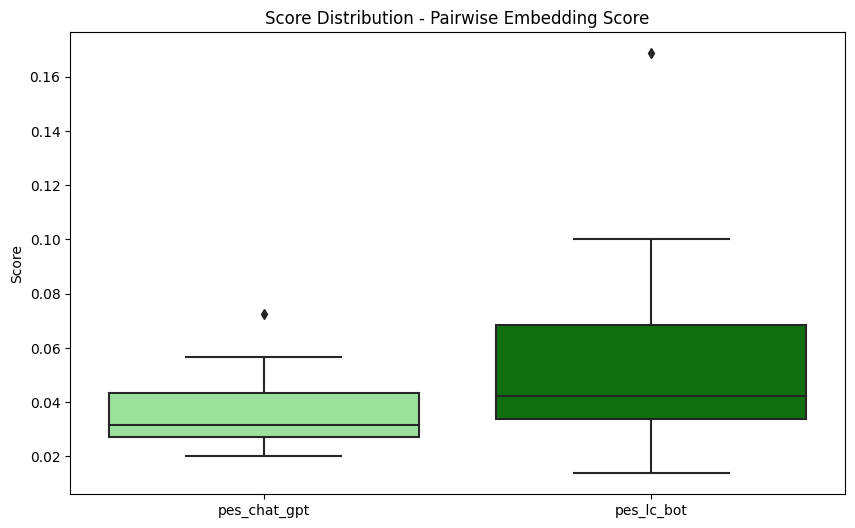

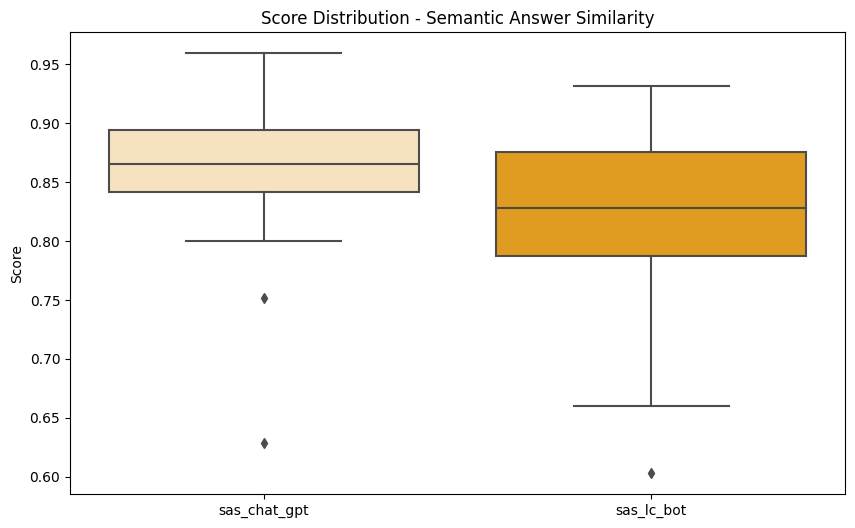

In [76]:
palette = {'pes_chat_gpt': 'lightgreen', 'pes_lc_bot': 'green',
           'sas_chat_gpt': 'moccasin', 'sas_lc_bot': 'orange'}

# boxplot for Pairwise Embedding Score
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=nlp_df[['pes_chat_gpt', 'pes_lc_bot']], orient='vertical', palette=palette)
ax.set_ylabel('Score')
ax.set_title('Score Distribution - Pairwise Embedding Score')
plt.show()

# boxplot for Semantic Answer Similarity
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=nlp_df[['sas_chat_gpt', 'sas_lc_bot']], orient='vertical', palette=palette)
ax.set_ylabel('Score')
ax.set_title('Score Distribution - Semantic Answer Similarity')
plt.show()
